In [1]:
import numpy as np
from time import process_time, perf_counter
from scipy import datasets
import matplotlib.pyplot as plt
from skimage import data, restoration

### Add Noise

Add gaussian noise to the image and some salt and pepper noise to the right side of the image.

In [2]:
def SnP_Noise(img, noise_factor = 0.15):

    row, col = img.shape

    max_number_of_pixels = row*col
    pixels_to_change = int(np.ceil(max_number_of_pixels*noise_factor*0.5))

    #Turn pixels white
    for i in range(pixels_to_change):
        #Select random pixel
        y_coord = np.random.randint(0, row-1)
        x_coord = np.random.randint(0, col-1)
        #Switch color
        img[y_coord,x_coord] = 1

    #Turn pixels black
    for i in range(pixels_to_change):
        #Select random pixel
        y_coord = np.random.randint(0, row-1)
        x_coord = np.random.randint(0, col-1)
        #Switch color
        img[y_coord,x_coord] = 0

    return img


def make_noisy(img, noise_factor = 0.15):
    # add gaussian noise
    img = img + noise_factor *0.5* np.random.normal(size=img.shape)
    # add some outliers in on the right side of the image
    w = int(np.floor(0.6*img.shape[1]))
    m = img[:, w:].copy()
    noised_m =SnP_Noise(m,noise_factor)
    img[:, w:] = noised_m

    return img

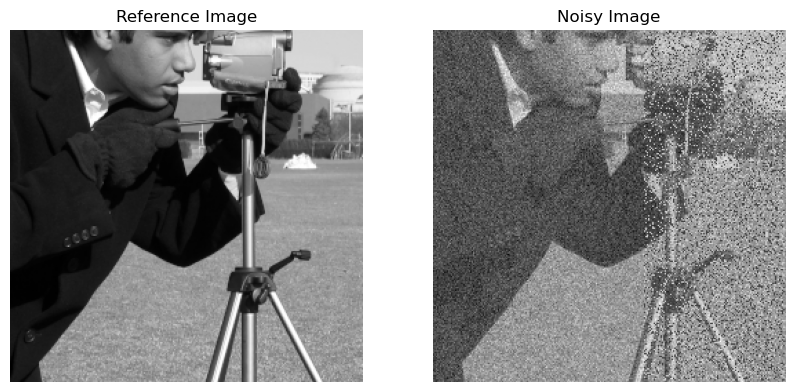

In [3]:
demo_pic = datasets.ascent()
demo_pic = data.camera()[140:,120:][:256,:256] / 255.0
noised_pic = make_noisy(demo_pic.copy(), 0.25)

plt.figure(figsize=(10, 5))
plt.gray()

# Show the first image (img_ref) in the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(demo_pic)
plt.title('Reference Image')
plt.axis('off')  # turn off axes

# Show the second image (img_obs) in the right
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(noised_pic)
plt.title('Noisy Image')
plt.axis('off')  # turn off axes

# Display the images

plt.show()

### Definition of Operators

We implement $K=\nabla$ via finite differences.

In [4]:
def grad(u):
    shape = [u.ndim,]+list(u.shape)
    K = np.zeros(shape, dtype=u.dtype)
    #for each dimension compute the finite difference wrt to the dimension
    #The filter is build as follows: Choose 0th dimension and pick entries 0:-1 ->K[0,:-1,:]
    #Later it will be updated such that the filter gets K[1, :, :-1]
    filter = [0, slice(0,-1),]
    for dim in range(u.ndim):
        K[tuple(filter)]=np.diff(u, axis= dim)
        Z=np.diff(u, axis= dim)
        #Update filter
        filter[0]=dim + 1
        filter.insert(1, slice(None))
    return K


The adjoint operator $K^T=\mathrm{div}$ can be implemented in several ways. We present three options: Applying finite differences a second time, a straightforward definition given by Chambolle in [1], a finite differences definition with different handling of the boundary.

---
[1] Chambolle, A. An Algorithm for Total Variation Minimization and Applications. Journal of Mathematical Imaging and Vision 20, 89–97 (2004).

In [5]:
def div(grad):
    Divergence = np.zeros(grad.shape[1:], dtype=grad.dtype)
    filter = [slice(1,None),]
    for dim in range(grad.shape[0]):
        D=grad[dim].copy()
        D[tuple(filter)]=np.diff(grad[dim], axis= dim)
        Divergence += D
        filter.insert(0, slice(None))
    return Divergence


def Chambolle_div(grad):
    div_p_0 = np.zeros_like(grad[0])
    div_p_1 = np.zeros_like(grad[0])
    for i in range(grad[0].shape[0]):
        if i== 0:
            div_p_0[i,:]=grad[0,i,:]
        elif i==grad[0].shape[0]-1:
            div_p_0[i,:]=-grad[0,i-1,:]
        else:
            div_p_0[i,:]=grad[0,i,:]-grad[0,i-1,:]
    for j in range(grad[0].shape[1]):
        if j== 0:
            div_p_1[:,j]=grad[1,:,j]
        elif j==grad[0].shape[1]-1:
            div_p_1[:,j]=-grad[1,:,j-1]
        else:
            div_p_1[:,j]=grad[1,:,j]-grad[1,:,j-1]
    Divergence = div_p_0+div_p_1
    return Divergence


def nablaT(grad):
    h, w = grad.shape[1:]
    Divergence = np.zeros((h, w),grad.dtype)
    # note that we just reversed left and right sides
    # of each line to obtain the transposed operator
    Divergence[:, :-1] -= grad[1, :, :-1]
    Divergence[:, 1: ] += grad[1, :, :-1]
    Divergence[:-1]    -= grad[0,:-1, :]
    Divergence[1: ]    += grad[0,:-1, :]
    return Divergence

In [6]:
gradient = grad(noised_pic)

begin = perf_counter()
div1 = div(gradient)
t1 = perf_counter()
print("Time needed: ",t1-begin)
div2 = Chambolle_div(gradient)
t2 = perf_counter()
print("Time needed: ",t2-t1)
div3 = nablaT(gradient)
t3 = perf_counter()
print("Time needed: ",t3-t2)
norm_diff1 = np.linalg.norm(div1-div2)
norm_diff2 = np.linalg.norm(div1-div3)
print("||div1-div2||=",norm_diff1)
print("||div1-div3||=",norm_diff2)

Time needed:  0.000361640000164698
Time needed:  0.001958336999905441
Time needed:  0.0004497659999742609
||div1-div2||= 0.0
||div1-div3||= 465.43622329852167


The first two implementations lead to the same result. However, the first one is faster and more flexible which is why we will stick to this in the next steps. The thrid one leads to a different result. We will compare the performance of them later. As a proof of concept we first compare their operator norms.

In [7]:
def operator_norm_estimator(K, K_T, max_iter=25):
    """
    Estimate the operator norm through power method.
    """
    shape=(500,500)
    u = np.random.randn(*shape)
    u /= np.linalg.norm(u)
    for _ in range(max_iter):
        Ku = K(u)
        KT_Ku = K_T(Ku)
        norm = np.linalg.norm(KT_Ku)
        u = KT_Ku / norm

    return np.sqrt(np.sum(np.sum(K(u)**2, axis=0)))

In [8]:
L1 = operator_norm_estimator(grad, div, 50)
L2 = operator_norm_estimator(grad, nablaT, 50)
print("L1^2=",L1**2, ", L2^2=", L2**2)

L1^2= 7.91798786975437 , L2^2= 7.917592415227969


### Energy and proximal operators
Note that by definition $\vert (\nabla u)_{i,j}\vert = \sqrt{((\nabla u)^1_{i,j})^2+((\nabla u)^2_{i,j})^2}$. The ROF model is defined as the variational problem $ \min_{u} \int_\Omega \vert Du\vert +\frac{\lambda}{2} \Vert u-g\Vert_2^2.$ So the energy that needs to be minimized is $E_{ROF}(u)=\Vert \nabla u\Vert_1 +\frac{\lambda}{2} \Vert u-g\Vert_2^2$ where $\Vert \nabla u\Vert_1 =\sum_{i,j}\vert (\nabla u)_{i,j}\vert$.

In [9]:
def abs_grad(x):
    return np.sqrt(np.sum(x**2, axis=0))

def calc_energy_ROF(u, g, lamb):
    TV = abs_grad(grad(u)).sum()
    Fidelity = 0.5 * lamb * ((u - g)**2).sum()
    return TV + Fidelity, TV, Fidelity

The primal-dual forulation of the ROF problem is given by $$\min_{u\in X}\max_{p\in Y} - \langle u, \textrm{div }p \rangle_X +\frac{\lambda}{2} \Vert u-g\Vert_2^2-\delta_P(p)$$ where $P=\{p\in Y:\Vert p\Vert_\infty\leq 1\}$ and $\delta_P$ is the indicator function. So $F^*(p)=\delta_P(p)$ and $G(u)= \frac{\lambda}{2} \Vert u-g\Vert_2^2$ and therefore a short calculation yields $$p=(I+\sigma\partial F^*)^{-1}(\tilde{p})\Leftrightarrow p_{i,j}=\frac{\tilde{p}_{i,j}}{\mathrm{max}(1,\vert \tilde{p}_{i,j}\vert)}$$ and $$u=(I+\tau\partial G)^{-1}(\tilde{u}) \Leftrightarrow u_{i,j}=\frac{\tilde{u}_{i,j}+\tau \lambda g_{i,j}}{1+\tau\lambda}.$$

In [10]:
def F_conj(p):
    norm = np.max(abs_grad(p))
    if norm<= 1.00002:
        return 0
    else:
        return np.inf

def G(u, g, lamb):
    fidelity = calc_energy_ROF(u, g, lamb)[2]
    return fidelity

def prox_F_conj(p):
    proj = np.zeros_like(p)
    nP = np.maximum(1.0, abs_grad(p))
    proj = p/nP
    return proj

def ROF_prox_G(u, g, lamb, tau):
    lt = lamb * tau
    return (u + lt * g) / (1.0 + lt)

### The primal-dual algorithm

We use the following algorithm from [2]. Let $X,Y$ be two Hilbert spaces and $K\colon X\to Y$ a continuous linear operator with induced norm $\Vert K\Vert =\mathrm{max}\{\Vert Kx\Vert\colon x\in X\text{ with }\Vert x\Vert \leq 1\}$. The problem which is considered is the saddle-point problem $$\min_{x\in X}\max_{y\in Y}\langle Kx,y\rangle+G(x)-F^*(y)$$ where $G\colon X\to [0,+\infty]$ and $F^*\colon Y\to [0,+\infty]$ are proper, convex, lower-semicontinuous functions and $F^*$ being itself the convex conjugate of a convex l.s.c. function $F$.

**Algorithm**

Initialization: Choose $\tau,\sigma >0$, $\theta\in [0,1]$, $(x^0,y^0)\in X\times Y$ and set $\overline{x}^0=x^0$.\\
Iterations ($n\geq  0$): Update $x^n, y^n, \overline{x}^n$ as follows: $$\left\{ \begin{array}{l}
	y^{n+1}=(I+\sigma \partial F^*)^{-1}(y^n+\sigma K\overline{x}^n)\\
	x^{n+1}=(I+\tau \partial G)^{-1}(x^n-\tau K^* y^{n+1})\\
    \overline{x}^{n+1}= x^{n+1}+\theta(x^{n+1}-x^n)
	\end{array} \right.$$
If the problem has a saddle-point, then by choosing $\theta=1$ and $\tau\sigma L^2<1$ for $L=\Vert K\Vert$ we find saddle-points of the problem by applying the algorithm.


---
[2] Chambolle, A., Pock, T. A First-Order Primal-Dual Algorithm for Convex Problems with Applications to Imaging. J Math Imaging Vis 40, 120–145 (2011). 

In [11]:
def primaldual(E, f_conj, g, prox_f_conj, prox_g, K, K_T, x0, y0, sigma, tau, numb_iter=100, tracking=False):

    begin = perf_counter() 

    #Initialization
    theta = 1.0
    x, y, z = x0, y0, x0

    if tracking == True:
        energy, tv, fidelity = E(x0,y0)
        Prod = -np.sum(x0*K_T(y0))
        G = g(x0)
        F = f_conj(y0)

        energies = [energy,]
        TVs = [tv,]
        fidelities = [fidelity,]
        descent = [Prod+G,]
        ascent = [Prod-F,]
        pd = [Prod+G-F]

        time_list = [process_time() - begin]

    for i in range(numb_iter):
        #Update Steps
        y = prox_f_conj(y + sigma * K(z), sigma)
        if tracking == True:
            Prod = -np.sum(x*K_T(y))
            G = g(x)
            F = f_conj(y)
            pd.append(Prod+G-F)
        x1 = prox_g(x - tau * K_T(y), tau)
        z = x1 + theta * (x1 - x)
        x = x1

        if tracking == True:
            e,t,f = E(x,y)
            energies.append(e)
            TVs.append(t)
            fidelities.append(f)

            Prod = -np.sum(x*K_T(y))
            G = g(x)
            F = f_conj(y)
            descent.append(Prod+G)
            ascent.append(Prod-F)
            pd.append(Prod+G-F)
            
            time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("----- Primal-dual method -----")
    print("Time execution:", end - begin)
    if tracking == True:
        return [x, y, time_list, energies, TVs, fidelities, descent, ascent, pd]
    else:
        return [x,y]

### Execution of Algorithm

We know that we have to choose $\sigma$ and $\tau$ such that $\sigma \tau L^2<1$ to secure the convergence. That is why we choose $\sigma=\tau=\frac{1}{L}$. As initial guesses we use the noisy image. We use the nablaT implementation for the divergence as this produces the better result from a visual point of view, cf. below. As rigorous analysis follws also below. Note that for different choices of lambda we expect a different tradoff between smoothness of the image and closeness to the original image.

----- Primal-dual method -----
Time execution: 0.9271626620000006
----- Primal-dual method -----
Time execution: 0.9158810559999893
----- Primal-dual method -----
Time execution: 0.9799603429999024
----- Primal-dual method -----
Time execution: 1.0135386479998942


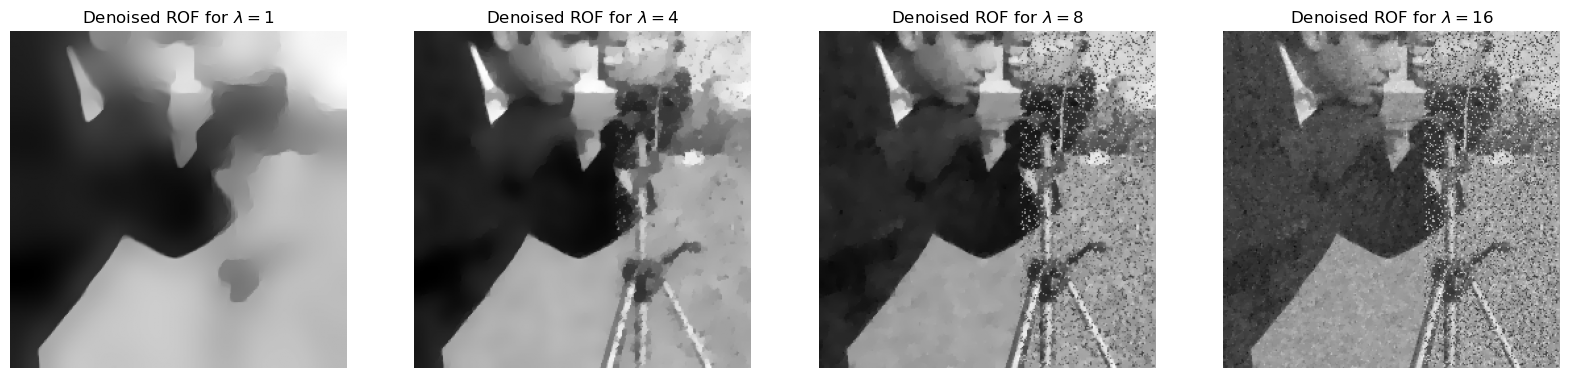

In [12]:
#Setup

K = lambda x: grad(x)
K_T = lambda x: nablaT(x)
approx_grad_norm = operator_norm_estimator(K, K_T, 150)
L = approx_grad_norm
sigma = 1/L
tau = 1/L
u0 = noised_pic
p0 = K(noised_pic)

iterations = 200

results = []
lambdas = [1,4,8,16]

for Lamb in lambdas:
    prox_g = lambda u, tau: ROF_prox_G(u, noised_pic, Lamb, tau)
    prox_f = lambda p, sigma: prox_F_conj(p)
    g_lambda = lambda u: G(u, noised_pic, Lamb)
    f_conj = F_conj

    energy = lambda u, p: calc_energy_ROF(u, noised_pic, Lamb)

    res = primaldual(energy, f_conj, g_lambda, prox_f, prox_g, K, K_T, u0, p0, sigma, tau, numb_iter=iterations, tracking=True)

    results.append(res)

plt.figure(figsize=(20, 10))
plt.gray()
l = len(results)
for i in range(len(results)):
    plt.subplot(1, len(results), i+1)  
    plt.imshow(results[i][0])
    plt.title(f'Denoised ROF for $\lambda=${lambdas[i]}')
    plt.axis('off') 
plt.show()



If we choose the alternative definition of the divergence as proposed by Chambolle we obtain the following result.

----- Primal-dual method -----
Time execution: 1.026767358999905
----- Primal-dual method -----
Time execution: 0.9608541190000324
----- Primal-dual method -----
Time execution: 0.9991929140001048
----- Primal-dual method -----
Time execution: 0.9872159999999894


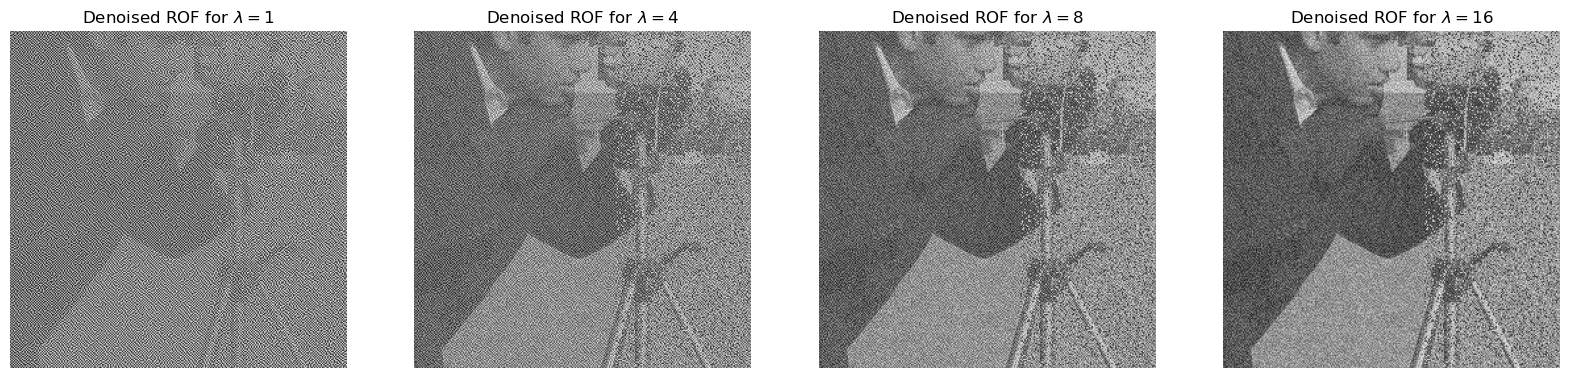

In [13]:
#Setup
K_T = lambda x: div(x)

results2 = []
lambdas = [1,4,8,16]

for Lamb in lambdas:
    prox_g = lambda u, tau: ROF_prox_G(u, noised_pic, Lamb, tau)
    prox_f = lambda p, sigma: prox_F_conj(p)
    g_lambda = lambda u: G(u, noised_pic, Lamb)
    f_conj = F_conj

    energy = lambda u, p: calc_energy_ROF(u, noised_pic, Lamb)

    res = primaldual(energy, f_conj, g_lambda, prox_f, prox_g, K, K_T, u0, p0, sigma, tau, numb_iter=iterations, tracking=True)

    results2.append(res)

plt.figure(figsize=(20, 10))
plt.gray()
l = len(results2)
for i in range(len(results2)):
    plt.subplot(1, len(results2), i+1)  
    plt.imshow(results2[i][0])
    plt.title(f'Denoised ROF for $\lambda=${lambdas[i]}')
    plt.axis('off') 
plt.show()

### Numerical analysis

For fixed $\lambda=8$ we now examine the algorithm and compare the impact of the two definitions of the adjoint operator.

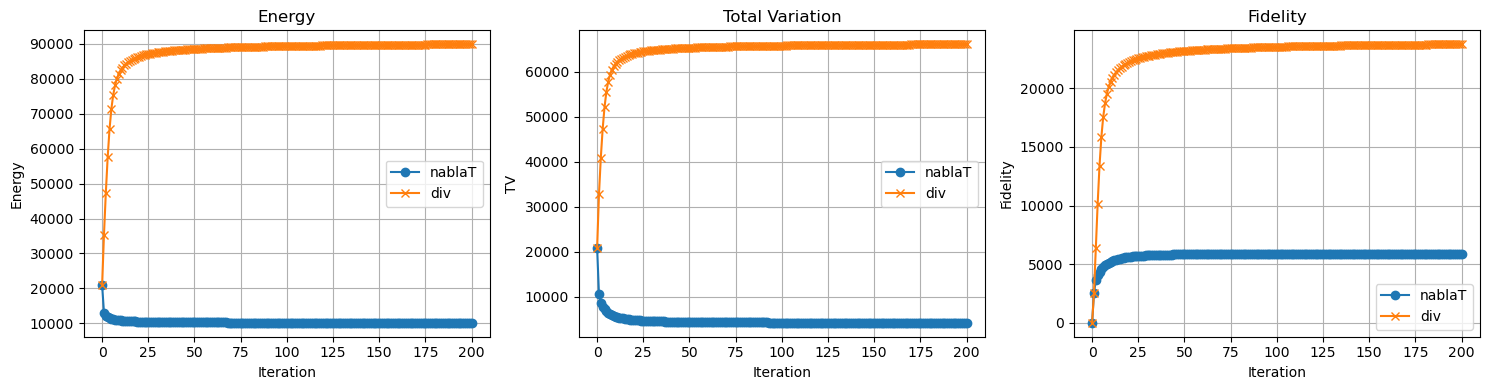

In [14]:
lambda_index = 2
nablaT_res = results[lambda_index]
div_res = results2[lambda_index]

energy_nablaT = nablaT_res[3]
tv_nablaT = nablaT_res[4]
fidelity_nablaT = nablaT_res[5]

energy_div = div_res[3]
tv_div = div_res[4]
fidelity_div = div_res[5]

# Plot
plt.figure(figsize=(15, 4))

# Energy
plt.subplot(1, 3, 1)
plt.plot(energy_nablaT, label='nablaT', marker='o')
plt.plot(energy_div, label='div', marker='x')
plt.title('Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)

# Total Variation
plt.subplot(1, 3, 2)
plt.plot(tv_nablaT, label='nablaT', marker='o')
plt.plot(tv_div, label='div', marker='x')
plt.title('Total Variation')
plt.xlabel('Iteration')
plt.ylabel('TV')
plt.legend()
plt.grid(True)

# Fidelity
plt.subplot(1, 3, 3)
plt.plot(fidelity_nablaT, label='nablaT', marker='o')
plt.plot(fidelity_div, label='div', marker='x')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Compairing the energy to another minimzer of the ROF problem obtained by the skimage-function implementing a dual maximising algorithm shows the following.

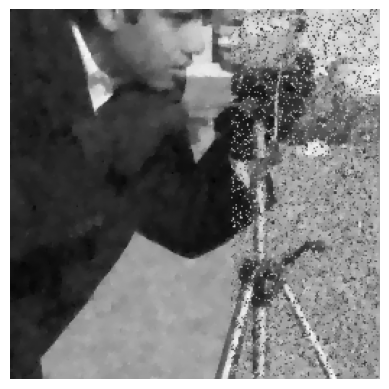

In [15]:
Lamb=lambdas[lambda_index]

sk_denoised_pic = restoration.denoise_tv_chambolle(noised_pic, 1/Lamb, max_num_iter = iterations)

plt.gray()
plt.axis("off")
plt.imshow(sk_denoised_pic)
plt.show()

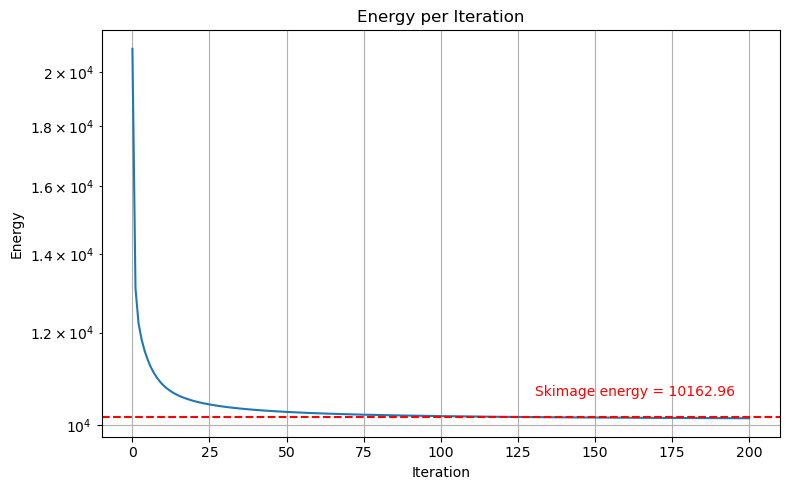

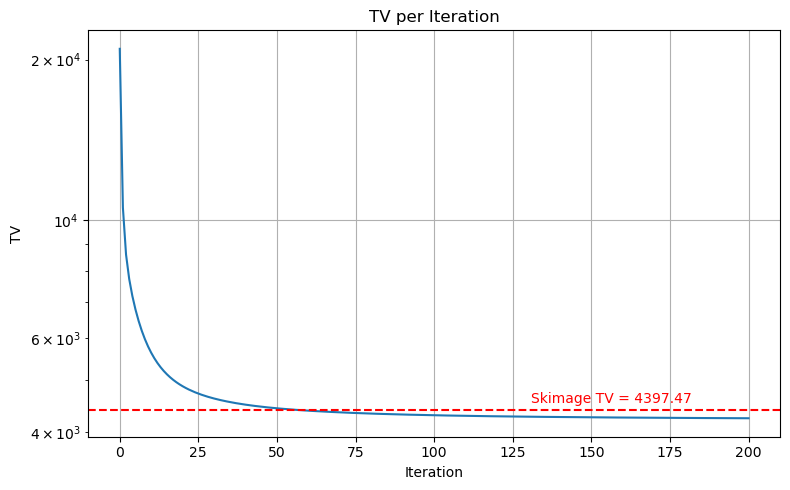

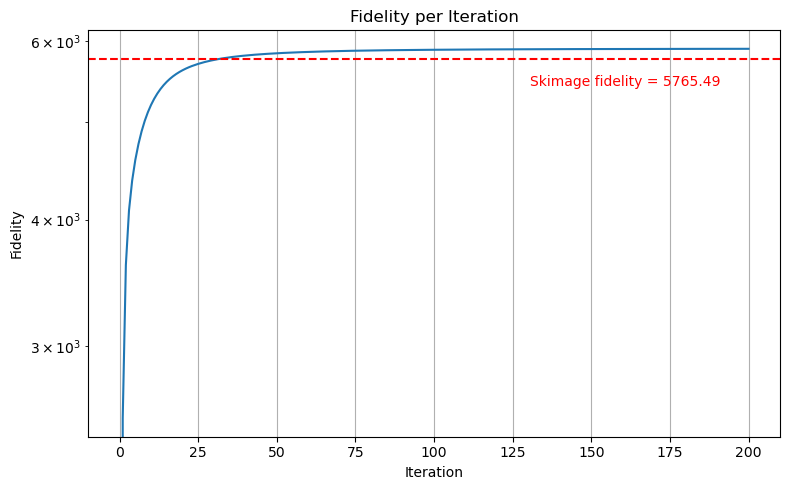

In [16]:
E, T, F = calc_energy_ROF(sk_denoised_pic, noised_pic, Lamb)

plt.figure(0, figsize=(8, 5))
plt.plot(energy_nablaT, linestyle='-')
plt.axhline(y=E, color='red', linestyle='--')
plt.text(len(energy_nablaT)*0.65, E+0.05*E, f"Skimage energy = {E:.2f}", color='red', va='center')
plt.yscale("log")
plt.title("Energy per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True)
plt.tight_layout()

plt.figure(1, figsize=(8, 5))
plt.plot(tv_nablaT, linestyle='-')
plt.axhline(y=T, color='red', linestyle='--')
plt.text(len(tv_nablaT)*0.65, T+0.05*T, f"Skimage TV = {T:.2f}", color='red', va='center')
plt.yscale("log")
plt.title("TV per Iteration")
plt.xlabel("Iteration")
plt.ylabel("TV")
plt.grid(True)
plt.tight_layout()

plt.figure(2, figsize=(8, 5))
plt.plot(fidelity_nablaT, linestyle='-')
plt.axhline(y=F, color='red', linestyle='--')
plt.text(len(fidelity_nablaT)*0.65, F-0.05*F, f"Skimage fidelity = {F:.2f}", color='red', va='center')
plt.yscale("log")
plt.title("Fidelity per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fidelity")
plt.grid(True)
plt.tight_layout()

plt.show()

### Ascent steps and descent steps

The primal-dual algorithm is based on maximizing $\langle Kx, y\rangle- F^*(y)$ for fixed $x$ by performing a proximal gradient ascent step in each iteration and minimizing $\langle Kx, y\rangle + G(x)$ for fixed $y$ by performing a proximal gradient descent step in each iteration. This can be observed numerically.

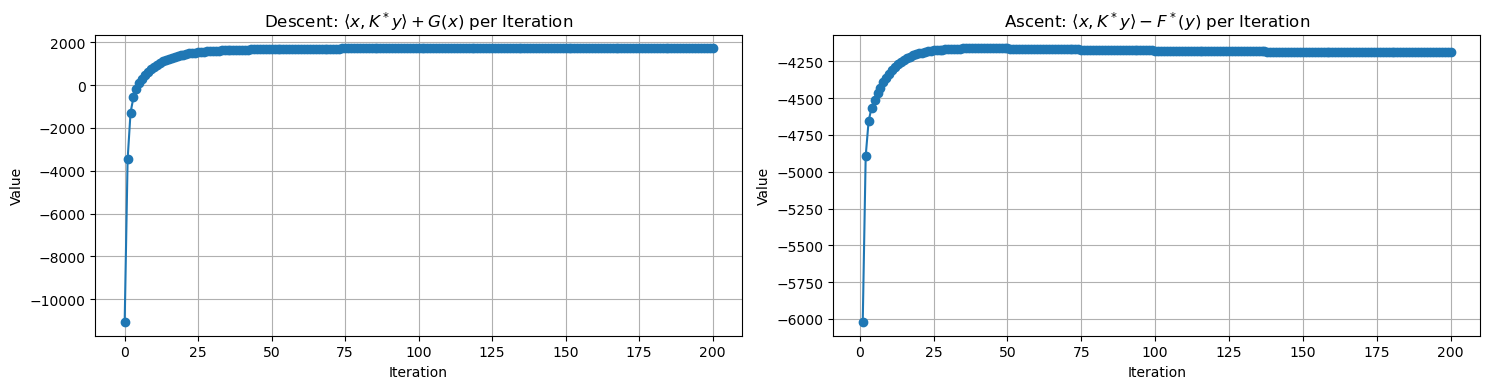

In [17]:
descent = nablaT_res[6]
ascent = nablaT_res[7]

plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(descent, marker='o', linestyle='-')
plt.title(r"Descent: $\langle x,K^*y\rangle + G(x)$ per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(ascent, marker='o', linestyle='-')
plt.title(r"Ascent: $\langle x, K^*y\rangle - F^*(y)$ per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

The two plots are probably misleading: we have a decent/ascent for fixed $y$/$x$ but here both are not fixed. The next plot should clarify this as we evaluate the whole functional after each proximal gradient step, in particular a fixed variable.

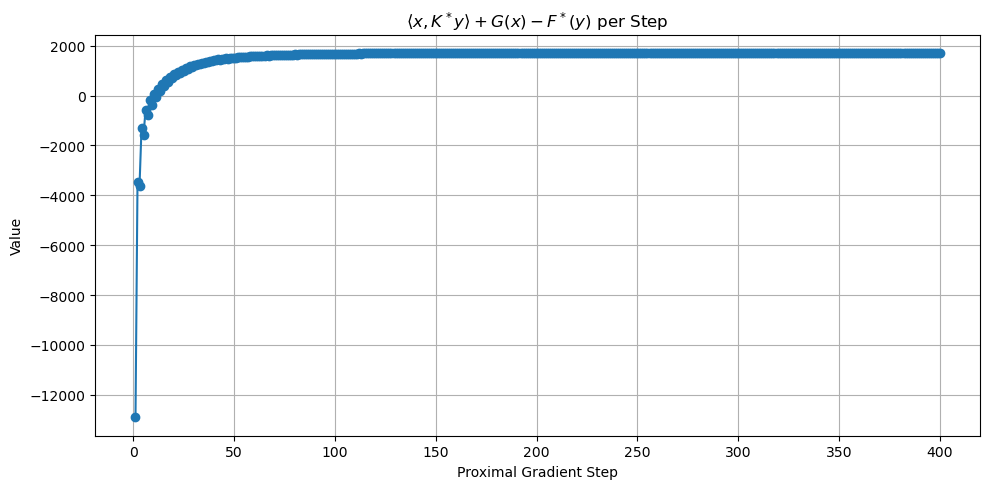

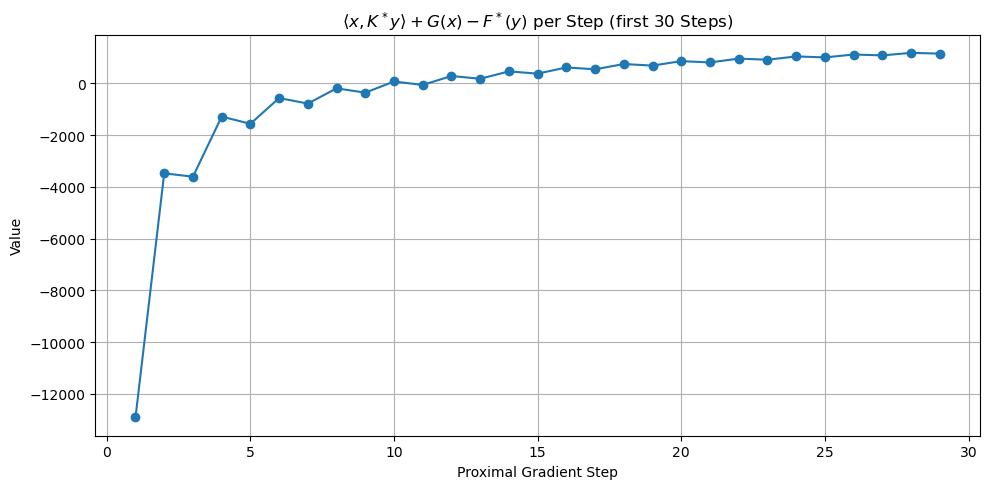

In [18]:
pd = nablaT_res[8]

plt.figure(1,figsize=(10, 5))
plt.plot(pd, marker='o', linestyle='-')
plt.title(r"$\langle x,K^*y\rangle + G(x)-F^*(y)$ per Step")
plt.xlabel("Proximal Gradient Step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.figure(2,figsize=(10, 5))
plt.plot(pd[:30], marker='o', linestyle='-')
plt.title(r"$\langle x,K^*y\rangle + G(x)-F^*(y)$ per Step (first 30 Steps)")
plt.xlabel("Proximal Gradient Step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## The TV-L1 Model

This is a variant of the ROF model and is given by 
$$\min_u \Vert \nabla u\Vert_1+\lambda \Vert u-g\Vert_1$$
and the primal-dual problem is then given by 
$$ \min_{u\in X}\max_{p\in Y} -\langle u, \mathrm{div} p \rangle_X +\lambda\Vert u-g\Vert_1 -\delta_P(p).$$
So we can use our framwork by only adapting the proximal operator of $G(u)=\lambda\Vert u-g\Vert_1$ which is given by
$$u=(I+\tau \partial G)^{-1}(\tilde{u})\Leftrightarrow u_{i,j}=\begin{cases}\tilde{u}_{i,j}-\tau \lambda& \text{if }\tilde{u}_{i,j}-g_{i,j}>\tau \lambda\\ \tilde{u}_{i,j}+\tau\lambda & \text{if } \tilde{u}_{i,j}-g_{i,j}<-\tau\lambda\\ g_{i,j}&\text{if } \vert \tilde{u}_{i,j}-g_{i,j}\vert \leq \tau\lambda.\end{cases}$$


For the implementation we use the clip function that given an interval, values outside the interval are clipped to the interval edges. So $ u_{i,j}=\tilde{u}_{i,j}+\mathrm{clip}(g_{i,j}-\tilde{u}_{i,j},[-\tau\lambda,\tau\lambda])$ is evaluated as follows. For $\tilde{u}_{i,j}-g_{i,j}<-\tau\lambda$ we have $g_{i,j}-\tilde{u}_{i,j}>\tau\lambda$ and thus $u_{i,j}=\tilde{u}_{i,j}+\tau\lambda$. The rest follows analogously.

In [19]:
def calc_energy_TVL1(u, g, lamb):
    TV = abs_grad(grad(u)).sum()
    Fidelity =  lamb * ((u - g)).sum()
    return TV + Fidelity, TV, Fidelity

def TVL1_G(u, g, lamb):
    return lamb * ((u - g)).sum()

def TVL1_prox_G(X, F, lamb, tau):
    step = lamb*tau
    return X + np.clip(F - X, -step, step)

----- Primal-dual method -----
Time execution: 0.6770979410000564
----- Primal-dual method -----
Time execution: 0.679021941999963
----- Primal-dual method -----
Time execution: 0.681187158000057
----- Primal-dual method -----
Time execution: 0.6727426730001298


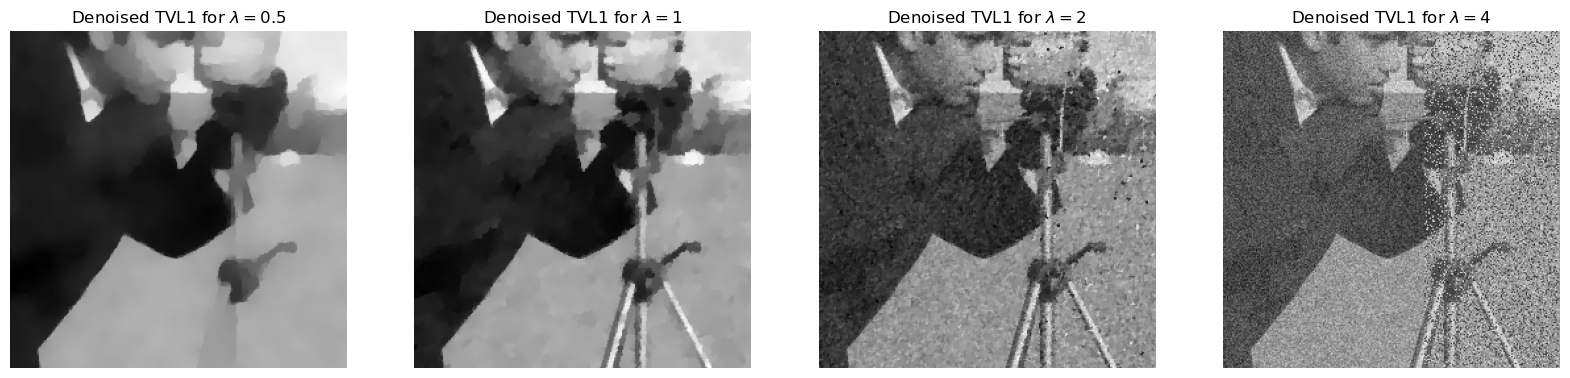

In [20]:
#Setup

K_T = lambda x: nablaT(x)

iterations = 200

results = []
lambdas = [0.5, 1, 2, 4]

for Lamb in lambdas:
    prox_g = lambda u, tau: TVL1_prox_G(u, noised_pic, Lamb, tau)
    prox_f = lambda p, sigma: prox_F_conj(p)
    g_lambda = lambda u: TVL1_G(u, noised_pic, Lamb)
    f_conj = F_conj

    energy = lambda u, p: calc_energy_TVL1(u, noised_pic, Lamb)

    res = primaldual(energy, f_conj, g_lambda, prox_f, prox_g, K, K_T, u0, p0, sigma, tau, numb_iter=iterations, tracking=True)

    results.append(res)

plt.figure(figsize=(20, 10))
plt.gray()
l = len(results)
for i in range(len(results)):
    plt.subplot(1, len(results), i+1)  
    plt.imshow(results[i][0])
    plt.title(f'Denoised TVL1 for $\lambda=${lambdas[i]}')
    plt.axis('off') 
plt.show()

### Numerical analysis

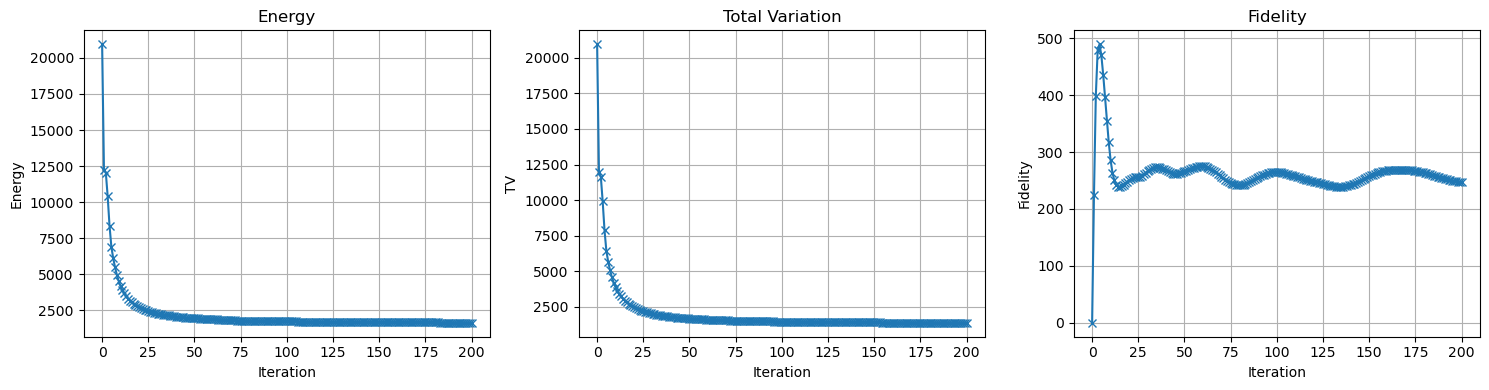

In [22]:
lambda_index = 1
res = results[lambda_index]

energy = res[3]
tv = res[4]
fidelity = res[5]

# Plot
plt.figure(figsize=(15, 4))

# Energy
plt.subplot(1, 3, 1)
plt.plot(energy, marker='x')
plt.title('Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid(True)

# Total Variation
plt.subplot(1, 3, 2)
plt.plot(tv, marker='x')
plt.title('Total Variation')
plt.xlabel('Iteration')
plt.ylabel('TV')
plt.grid(True)

# Fidelity
plt.subplot(1, 3, 3)
plt.plot(fidelity, marker='x')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.grid(True)

plt.tight_layout()
plt.show()

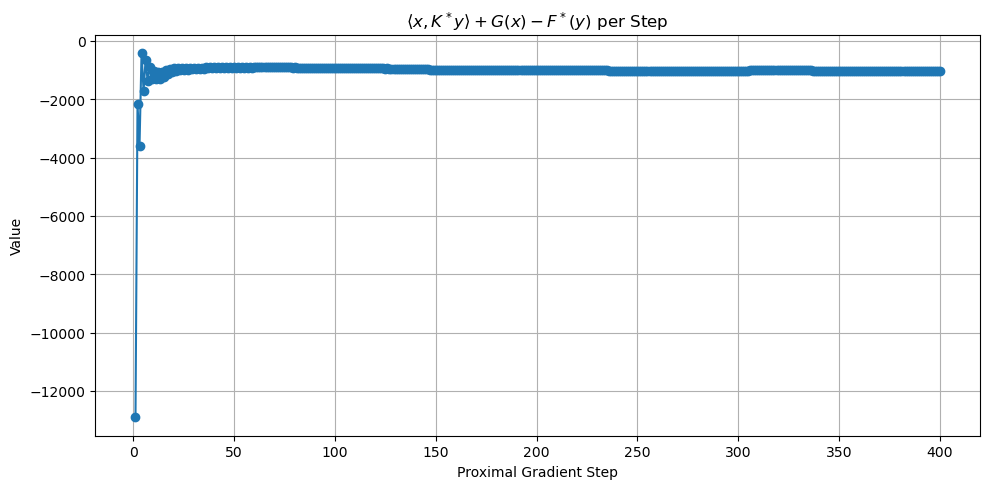

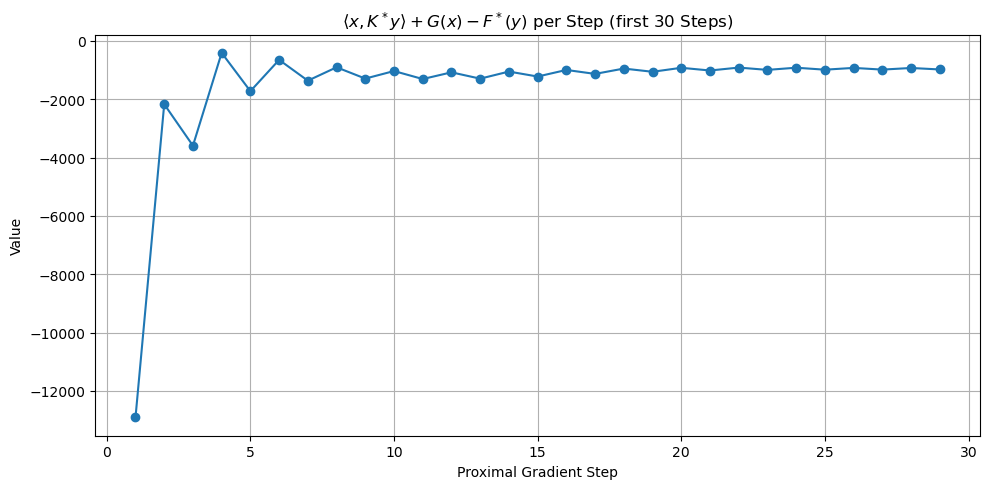

In [27]:
pd = res[8]

plt.figure(1,figsize=(10, 5))
plt.plot(pd, marker='o', linestyle='-')
plt.title(r"$\langle x,K^*y\rangle + G(x)-F^*(y)$ per Step")
plt.xlabel("Proximal Gradient Step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.figure(2,figsize=(10, 5))
plt.plot(pd[:30], marker='o', linestyle='-')
plt.title(r"$\langle x,K^*y\rangle + G(x)-F^*(y)$ per Step (first 30 Steps)")
plt.xlabel("Proximal Gradient Step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

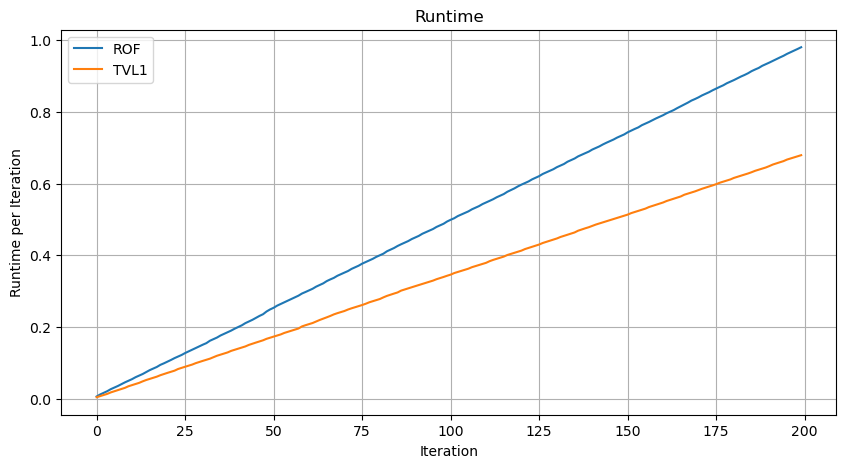

In [26]:
time_ROF = nablaT_res[2]
time_TVL1 = res[2]

plt.figure(figsize=(10, 5))
plt.plot(time_ROF[1:], label='ROF')
plt.plot(time_TVL1[1:], label='TVL1')
plt.title('Runtime')
plt.xlabel('Iteration')
plt.ylabel('Runtime per Iteration')
plt.legend()
plt.grid(True)